# FOMC Analysis
FOMC has eight regular meetings to determine the monetary policy. At each meeting, it publishes press conference minutes, statements as well as scripts in text. In addition to this regular meetings, the members’ speeches and testimonies are also scripted on the website.
At each meeting, the policy makers decide monetary policy and publish the decision along with their view on current economic situation and forecast, including Forward Guidance since 2012. The central banks intend to indicate their potential future monetary policy in their publications as a measure of market communication.
The objective of this project is to apply NLP on those text published by FOMC to find latent features. First, I apply machine learning to economic indices to see how the prediction performs. Then, add pre-processed text data as additional feature in traditional machine learning technique to see if it contains the meaningful information. Finally, apply Deep Learning technique such as LSTM/RNN and BERT to see if these can better predict the rate hike/lower at each FOMC meeting.
All data used in this analysis are publicly available.

<img src='../img/FomcMeetings.png' width=700>

FOMC Meeting documents are available here: https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm

The process followed in this project is dipicted as follows:

<img src='../img/process.png' width=800>

In [56]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import io
from dateutil.relativedelta import *

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pickle
from tqdm.notebook import tqdm
import re

plt.style.use('fivethirtyeight')
sns.set(style='white', context='notebook', palette='deep')
pd.options.display.max_rows = 20
%pprint

Pretty printing has been turned OFF


Run `fomc_get_calendar.py` to scrape FOMC Meeting calenadrs from FOMC wetbiste

In [57]:
file = open('../data/preprocessed/fomc_calendar.pickle', 'rb')
calendar_df = pickle.load(file)
calendar_df['RateDecision'] = calendar_df['RateDecision'].apply(lambda x: 'Raise' if x==1 else ('Lower' if x==-1 else 'Hold'))
file.close()
calendar_df[['ChairPerson', 'RateDecision', 'Rate', 'RateDiff']].iloc[:-3]


,ChairPerson,RateDecision,Rate,RateDiff
date,,,,
1982-10-05,Paul Volcker,Lower,9.50,-0.50
1982-11-16,Paul Volcker,Lower,9.00,-0.50
1982-12-21,Paul Volcker,Hold,8.50,0.00
1983-01-14,Paul Volcker,Hold,8.50,0.00
1983-01-21,Paul Volcker,Hold,8.50,0.00
...,...,...,...,...
2022-07-27,Jerome Powell,Raise,2.25,0.75
2022-09-21,Jerome Powell,Raise,3.00,0.75
2022-11-02,Jerome Powell,Raise,3.75,0.75


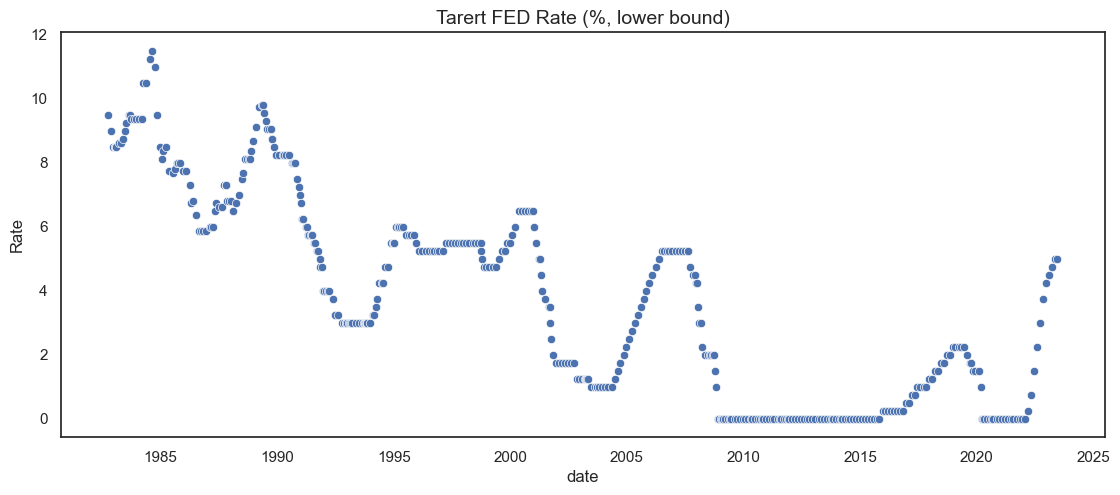

In [58]:
plt.figure(figsize=(12,5))
sns.scatterplot(x=calendar_df.index.get_level_values(0), y=calendar_df['Rate'])
plt.title('Tarert FED Rate (%, lower bound)', fontsize=14)
plt.show()

# 1. Download Economic Indices
Important economic indices are obtained from Economic Research in FRB of St. Louis Website called FRED (https://fred.stlouisfed.org/).
 - FED Target Rates (range)
 - GDP (Real, Real Estimate)
 - CPI / PCE
 - Employment and Unemployment
 - Retail Sales and Home Sales
 - ISM Purchasing Managers Index and Non-manufacturing Index

In [59]:
file = open('../data/preprocessed/nontext_data.pickle', 'rb')
meta_df = pickle.load(file)
file.close()
meta_df.columns

Index(['unscheduled', 'forecast', 'confcall', 'ChairPerson', 'Rate',
       'RateDiff', 'RateDecision', 'RateChanged', 'GDP_date', 'GDP_value',
       'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_date', 'GDPPOT_value',
       'GDPPOT_diff_prev', 'GDPPOT_diff_year', 'PCE_date', 'PCE_value',
       'PCE_diff_prev', 'PCE_diff_year', 'CPI_date', 'CPI_value',
       'CPI_diff_prev', 'CPI_diff_year', 'Unemp_date', 'Unemp_value',
       'Unemp_diff_prev', 'Unemp_diff_year', 'Employ_date', 'Employ_value',
       'Employ_diff_prev', 'Employ_diff_year', 'PMI_date', 'PMI_value',
       'PMI_diff_prev', 'PMI_diff_year', 'NMI_date', 'NMI_value',
       'NMI_diff_prev', 'NMI_diff_year', 'Rsales_date', 'Rsales_value',
       'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_date', 'Hsales_value',
       'Hsales_diff_prev', 'Hsales_diff_year', 'Taylor', 'Balanced', 'Inertia',
       'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff',
       'Balanced_diff', 'Inertia_diff'],
      dtype='object')

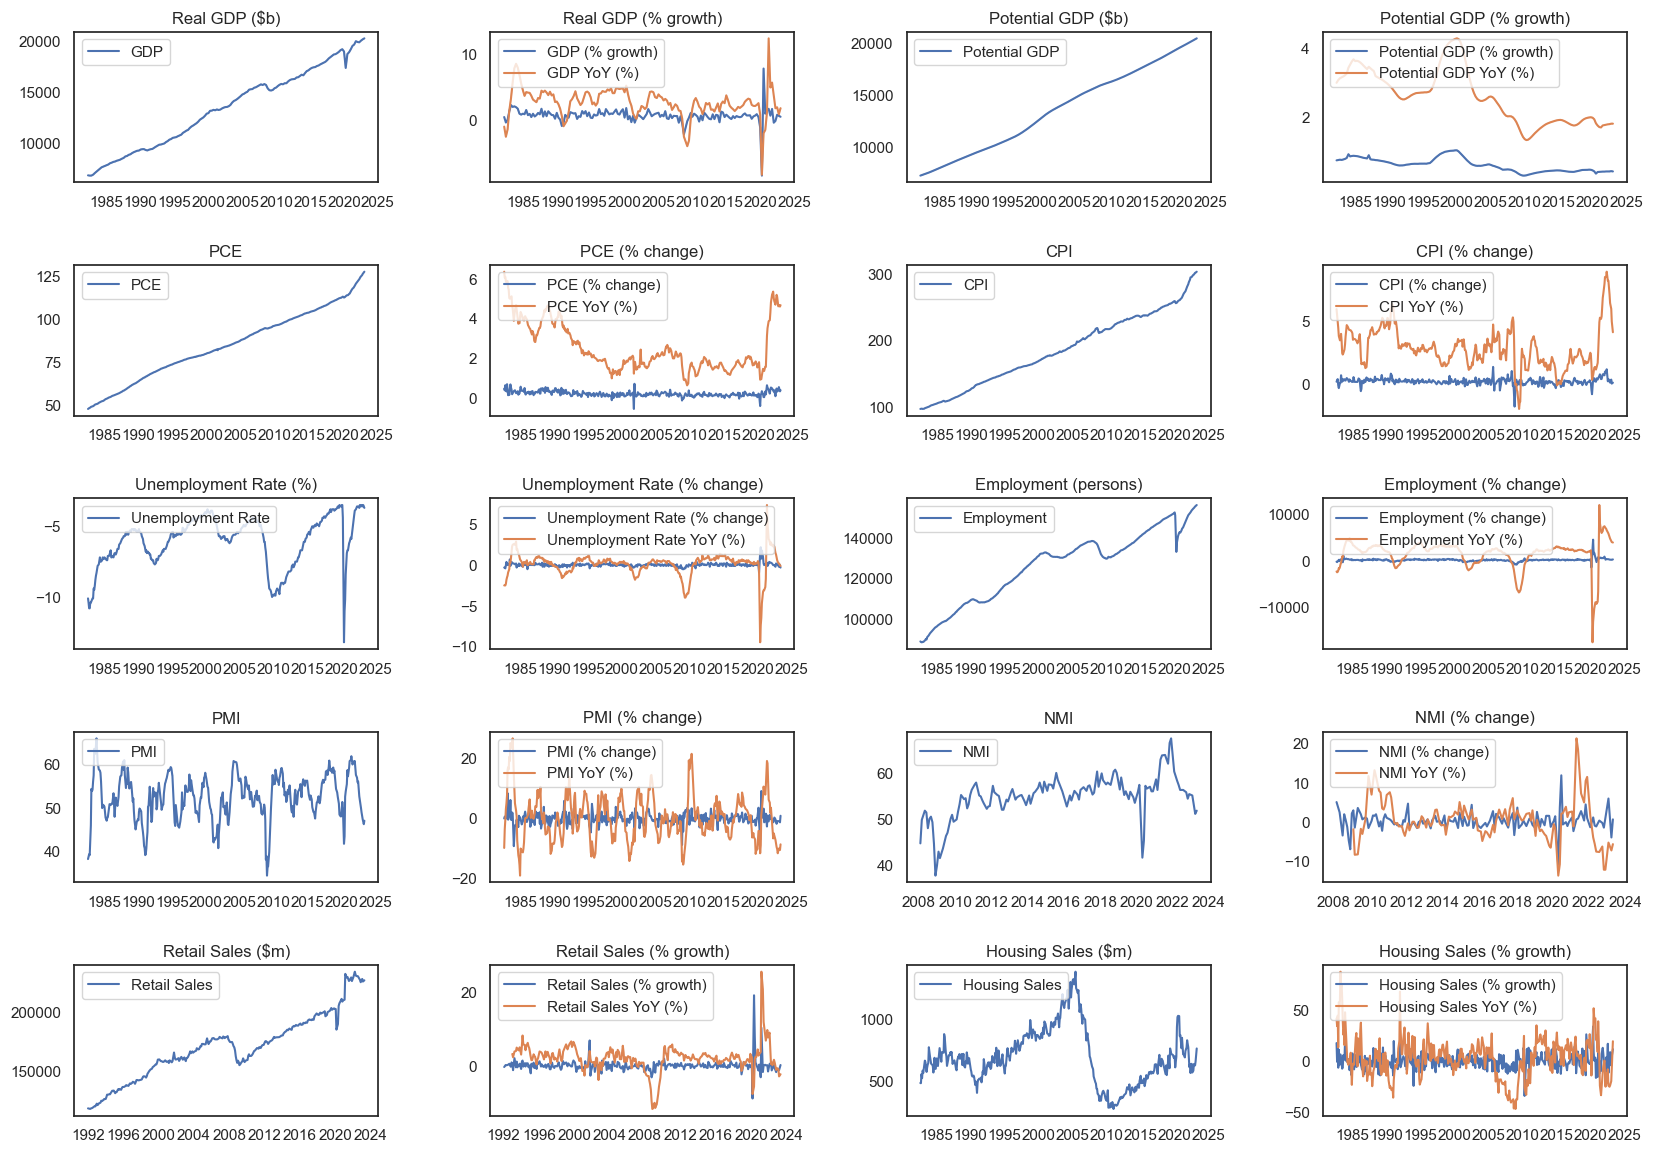

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(5, 4, figsize=(17, 12))

sns.lineplot(x=meta_df['GDP_date'], y=meta_df['GDP_value'].values, ax=axes[0][0], label='GDP')
sns.lineplot(x=meta_df['GDP_date'], y=meta_df['GDP_diff_prev'].values, ax=axes[0][1], label='GDP (% growth)')
sns.lineplot(x=meta_df['GDP_date'], y=meta_df['GDP_diff_year'].values, ax=axes[0][1], label='GDP YoY (%)')
sns.lineplot(x=meta_df['GDPPOT_date'], y=meta_df['GDPPOT_value'].values, ax=axes[0][2], label='Potential GDP')
sns.lineplot(x=meta_df['GDPPOT_date'], y=meta_df['GDPPOT_diff_prev'].values, ax=axes[0][3], label='Potential GDP (% growth)')
sns.lineplot(x=meta_df['GDPPOT_date'], y=meta_df['GDPPOT_diff_year'].values, ax=axes[0][3], label='Potential GDP YoY (%)')
sns.lineplot(x=meta_df['PCE_date'], y=meta_df['PCE_value'].values, ax=axes[1][0], label='PCE')
sns.lineplot(x=meta_df['PCE_date'], y=meta_df['PCE_diff_prev'].values, ax=axes[1][1], label='PCE (% change)')
sns.lineplot(x=meta_df['PCE_date'], y=meta_df['PCE_diff_year'].values, ax=axes[1][1], label='PCE YoY (%)')
sns.lineplot(x=meta_df['CPI_date'], y=meta_df['CPI_value'].values, ax=axes[1][2], label='CPI')
sns.lineplot(x=meta_df['CPI_date'], y=meta_df['CPI_diff_prev'].values, ax=axes[1][3], label='CPI (% change)')
sns.lineplot(x=meta_df['CPI_date'], y=meta_df['CPI_diff_year'].values, ax=axes[1][3], label='CPI YoY (%)')
sns.lineplot(x=meta_df['Unemp_date'], y=meta_df['Unemp_value'].values, ax=axes[2][0], label='Unemployment Rate')
sns.lineplot(x=meta_df['Unemp_date'], y=meta_df['Unemp_diff_prev'].values, ax=axes[2][1], label='Unemployment Rate (% change)')
sns.lineplot(x=meta_df['Unemp_date'], y=meta_df['Unemp_diff_year'].values, ax=axes[2][1], label='Unemployment Rate YoY (%)')
sns.lineplot(x=meta_df['Employ_date'], y=meta_df['Employ_value'].values, ax=axes[2][2], label='Employment')
sns.lineplot(x=meta_df['Employ_date'], y=meta_df['Employ_diff_prev'].values, ax=axes[2][3], label='Employment (% change)')
sns.lineplot(x=meta_df['Employ_date'], y=meta_df['Employ_diff_year'].values, ax=axes[2][3], label='Employment YoY (%)')
sns.lineplot(x=meta_df['PMI_date'], y=meta_df['PMI_value'].values, ax=axes[3][0], label='PMI')
sns.lineplot(x=meta_df['PMI_date'], y=meta_df['PMI_diff_prev'].values, ax=axes[3][1], label='PMI (% change)')
sns.lineplot(x=meta_df['PMI_date'], y=meta_df['PMI_diff_year'].values, ax=axes[3][1], label='PMI YoY (%)')
sns.lineplot(x=meta_df['NMI_date'], y=meta_df['NMI_value'].values, ax=axes[3][2], label='NMI')
sns.lineplot(x=meta_df['NMI_date'], y=meta_df['NMI_diff_prev'].values, ax=axes[3][3], label='NMI (% change)')
sns.lineplot(x=meta_df['NMI_date'], y=meta_df['NMI_diff_year'].values, ax=axes[3][3], label='NMI YoY (%)')
sns.lineplot(x=meta_df['Rsales_date'], y=meta_df['Rsales_value'].values, ax=axes[4][0], label='Retail Sales')
sns.lineplot(x=meta_df['Rsales_date'], y=meta_df['Rsales_diff_prev'].values, ax=axes[4][1], label='Retail Sales (% growth)')
sns.lineplot(x=meta_df['Rsales_date'], y=meta_df['Rsales_diff_year'].values, ax=axes[4][1], label='Retail Sales YoY (%)')
sns.lineplot(x=meta_df['Hsales_date'], y=meta_df['Hsales_value'].values, ax=axes[4][2], label='Housing Sales')
sns.lineplot(x=meta_df['Hsales_date'], y=meta_df['Hsales_diff_prev'].values, ax=axes[4][3], label='Housing Sales (% growth)')
sns.lineplot(x=meta_df['Hsales_date'], y=meta_df['Hsales_diff_year'].values, ax=axes[4][3], label='Housing Sales YoY (%)')

for i in range(len(axes)):
    for j in range(len(axes[i])):
        axes[i][j].set_xlabel("")
        if (j == 1) | (j == 3):
            axes[i][j].legend()

axes[0][0].set_title('Real GDP ($b)')
axes[0][1].set_title('Real GDP (% growth)')
axes[0][2].set_title('Potential GDP ($b)')
axes[0][3].set_title('Potential GDP (% growth)')
axes[1][0].set_title('PCE')
axes[1][1].set_title('PCE (% change)')
axes[1][2].set_title('CPI')
axes[1][3].set_title('CPI (% change)')
axes[2][0].set_title('Unemployment Rate (%)')
axes[2][1].set_title('Unemployment Rate (% change)')
axes[2][2].set_title('Employment (persons)')
axes[2][3].set_title('Employment (% change)')
axes[3][0].set_title('PMI')
axes[3][1].set_title('PMI (% change)')
axes[3][2].set_title('NMI')
axes[3][3].set_title('NMI (% change)')
axes[4][0].set_title('Retail Sales ($m)')
axes[4][1].set_title('Retail Sales (% growth)')
axes[4][2].set_title('Housing Sales ($m)')
axes[4][3].set_title('Housing Sales (% growth)')

#Adjust subplot spacing
plt.tight_layout(pad=2.0)

#Show the legends on top of each subplot
for ax in axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, loc='upper left')

plt.show()




# 2. Scraping FOMC Website
Run `fomc_get_data.py` to crawl and download texts from the wetbiste
<img src="../img/FomcWebsite.png" width="800">

### Sample statement

In [61]:
file = open('../data/preprocessed/text_no_split.pickle', 'rb')
text_df = pickle.load(file)
file.close()

In [62]:
print(text_df.loc[text_df['type']=='statement']['date'].iloc[-2].strftime('%Y-%m-%d'))
print('------------')
print(text_df.loc[text_df['type']=='statement']['text'].iloc[-2].replace(". ", ".\n\n"))

2023-06-14
------------
The Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run.

In support of these goals, the Committee decided to maintain the target range for the federal funds rate at 5 to 5-1/4 percent.

Holding the target range steady at this meeting allows the Committee to assess additional information and its implications for monetary policy.

In determining the extent of additional policy firming that may be appropriate to return inflation to 2 percent over time, the Committee will take into account the cumulative tightening of monetary policy, the lags with which monetary policy affects economic activity and inflation, and economic and financial developments.

In addition, the Committee will continue reducing its holdings of Treasury securities and agency debt and agency mortgage-backed securities, as described in its previously announced plans.

The Committee is strongly committed to returning inflation to its 2 percent 

### Sample minutes

In [63]:
print(text_df.loc[text_df['type']=='minutes']['date'].iloc[-1].strftime('%Y-%m-%d'))
print('------------')
print(text_df.loc[text_df['type']=='minutes']['text'].iloc[-1].replace(". ", ".\n\n"))

2023-06-14
------------
Developments in Financial Markets and Open Market OperationsThe manager turned first to a review of developments in financial markets.

Policy-sensitive rates increased over the intermeeting period, reflecting indications of continued resilience in the economy, persistently elevated core inflation, and reduced downside tail risks following the resolution of the debt limit.

The shift in policy expectations contributed significantly to higher Treasury yields.

The increase in nominal yields primarily reflected higher real rates rather than inflation compensation.

Broad equity prices rose, al­though the outperformance was concentrated in a handful of companies with a large market capitalization.

Cyclical sectors fared better than sectors that tend to appreciate in a downturn, suggesting some reduced investor concern about downside risks to growth.

Investor sentiment about the banking sector improved as perceived tail risks regarding regional banks appeared to h

In [64]:
print(text_df.loc[text_df['type']=='presconf_script']['date'].iloc[-1].strftime('%Y-%m-%d'))
print('------------')
print(text_df.loc[text_df['type']=='presconf_script']['text'].iloc[-1].replace(". ", ".\n\n"))

2023-06-14
------------
 Good afternoon.

 My colleagues and I remain squarely focused on our dual mandate to promote maximum employment and stable prices for the American people.

 We understand the hardship that high inflation is causing, and we remain strongly committed to bringing inflation back down to our 2 percent goal.

 Price stability is the responsibility of the Federal Reserve.

 Without price stability, the economy doesn’t work for anyone.

 In particular, without price stability, we will not achieve a sustained period of strong labor market conditions that benefit all.

Since early last year, the FOMC has significantly tightened the stance of monetary policy.

 We have raised our policy interest rate by 5 percentage points, and we’ve continued to reduce our securities holdings at a brisk pace.

 We’ve covered a lot of ground, and the full effects of our tightening have yet to be felt.

 In light of how far we’ve come in tightening policy, the uncertain lags with which mon

Text(0.5, 1.0, 'The number of text data')

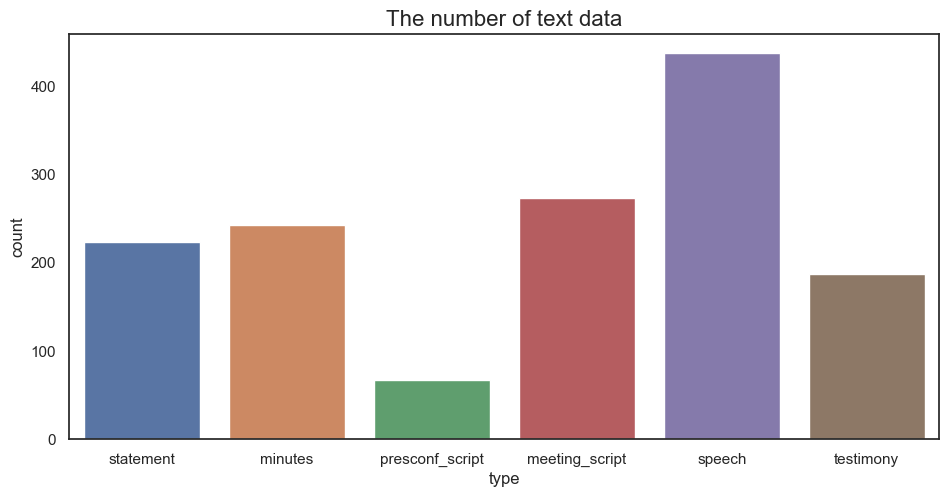

In [65]:
kwargs={'label': [1,2,3,4,5,6]}
plt.figure(figsize=(10,5))
sns.countplot(x='type', data=text_df.groupby(by=['type', 'date']).count().reset_index(),
             order=['statement', 'minutes', 'presconf_script', 'meeting_script', 'speech', 'testimony'], **kwargs)
plt.title('The number of text data', fontsize=16)

/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_828/1452357352.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(text_df.loc[text_df['type'] == 'statement']['word_count'], bins=20, ax=axes[0][0], kde=False, color='r')
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_828/1452357352.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.

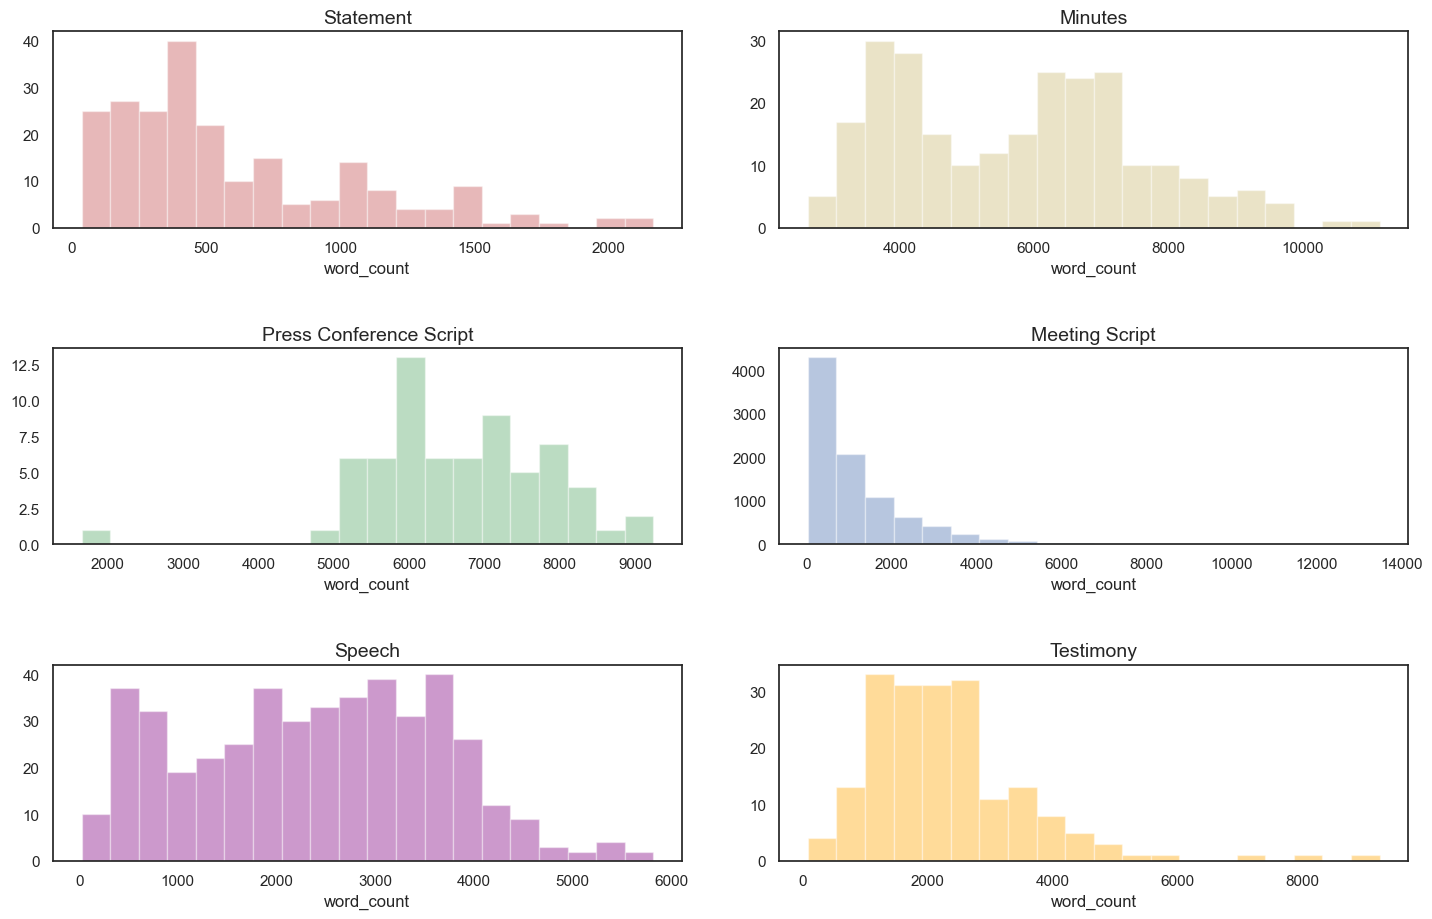

In [66]:
fig, axes = plt.subplots(3, 2, figsize=(15,10))
sns.distplot(text_df.loc[text_df['type'] == 'statement']['word_count'], bins=20, ax=axes[0][0], kde=False, color='r')
sns.distplot(text_df.loc[text_df['type'] == 'minutes']['word_count'], bins=20, ax=axes[0][1], kde=False, color='y')
sns.distplot(text_df.loc[text_df['type'] == 'presconf_script']['word_count'], bins=20, ax=axes[1][0], kde=False, color='g')
sns.distplot(text_df.loc[text_df['type'] == 'meeting_script']['word_count'], bins=20, ax=axes[1][1], kde=False, color='b')
sns.distplot(text_df.loc[text_df['type'] == 'speech']['word_count'], bins=20, ax=axes[2][0], kde=False, color='purple')
sns.distplot(text_df.loc[text_df['type'] == 'testimony']['word_count'], bins=20, ax=axes[2][1], kde=False, color='orange')
axes[0][0].set_title("Statement", fontsize=14)
axes[0][1].set_title("Minutes", fontsize=14)
axes[1][0].set_title("Press Conference Script", fontsize=14)
axes[1][1].set_title("Meeting Script", fontsize=14)
axes[2][0].set_title("Speech", fontsize=14)
axes[2][1].set_title("Testimony", fontsize=14)
fig.tight_layout(pad=3.0)
plt.show()

# 3. Preliminary Analysis of Statement Sentiment by Lexicon
Analyse statement by Loughran and McDonald word list to see if the relationship between economy and net sentiment.

The detail analysis can be found on `1_FOMC_Analysis_Preliminary.ipynb`

In [67]:
file = open("../data/train_data/text_df.pickle", "rb")
Data = pickle.load(file)
file.close()

In [68]:
Data.columns

Index(['type', 'date', 'title', 'speaker', 'word_count', 'decision', 'rate',
       'next_meeting', 'next_decision', 'next_rate', 'text', 'tone_score',
       'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words',
       'tokenized', 'token_ids', 'tfidf_Negative', 'tfidf_Uncertainty',
       'tfidf_Constraining', 'tfidf_Positive', 'tfidf_Litigious',
       'tfidf_Strong_Modal'],
      dtype='object')

In [69]:
stmt_df = Data.loc[Data['type']=='statement'].sort_values(['date']).set_index('date')

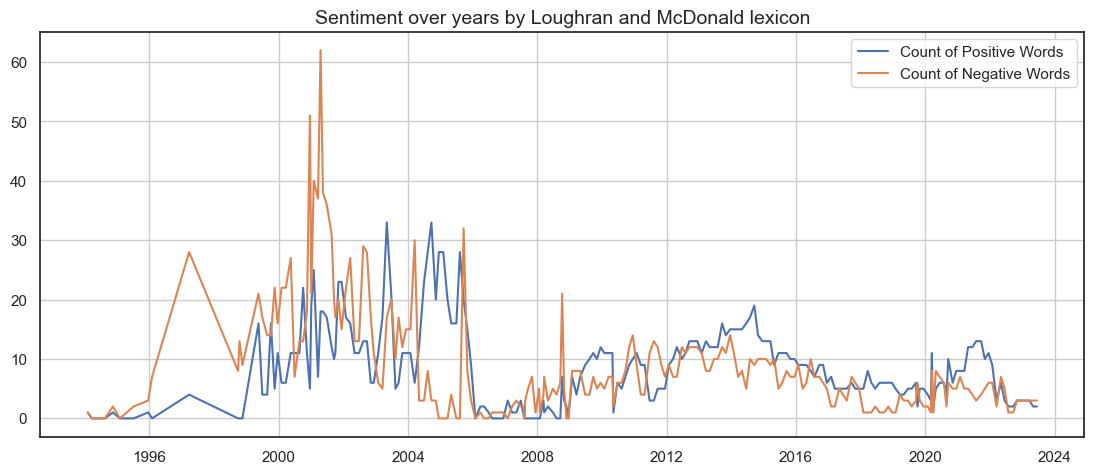

In [70]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(stmt_df[['n_pos_words', 'n_neg_words']]) 
plt.title('Sentiment over years by Loughran and McDonald lexicon', fontsize=14)
plt.legend(['Count of Positive Words', 'Count of Negative Words'])
ax.grid(True)

plt.show()

In [71]:
DotCom = np.logical_and(stmt_df.index > '2000-03', stmt_df.index < '2002-10') #Dot-com bubble
OhEight = np.logical_and(stmt_df.index > '2007-04', stmt_df.index < '2009-03') #Financial crisis of 2007–2008
EuroDebt = np.logical_and(stmt_df.index > '2010-09', stmt_df.index < '2012-09') #European debt crisis
Asian = np.logical_and(stmt_df.index > '2015-01', stmt_df.index < '2016-06') #2015–16 Chinese stock market turbulence
Corona = np.logical_and(stmt_df.index > '2020-03', stmt_df.index < '2020-12') #Coronavirus
Recessions = np.logical_or.reduce((DotCom, OhEight, EuroDebt, Asian, Corona))

Greenspan = np.logical_and(stmt_df.index > '1987-08-11', stmt_df.index < '2006-01-31')
Bernanke = np.logical_and(stmt_df.index > '2006-02-01', stmt_df.index < '2014-01-31')
Yellen = np.logical_and(stmt_df.index > '2014-02-03', stmt_df.index < '2018-02-03')
Powell = np.logical_and(stmt_df.index > '2018-02-05', stmt_df.index < '2022-02-05')
chair = np.logical_or.reduce((Greenspan, Yellen))


NameError: name 'recessions' is not defined

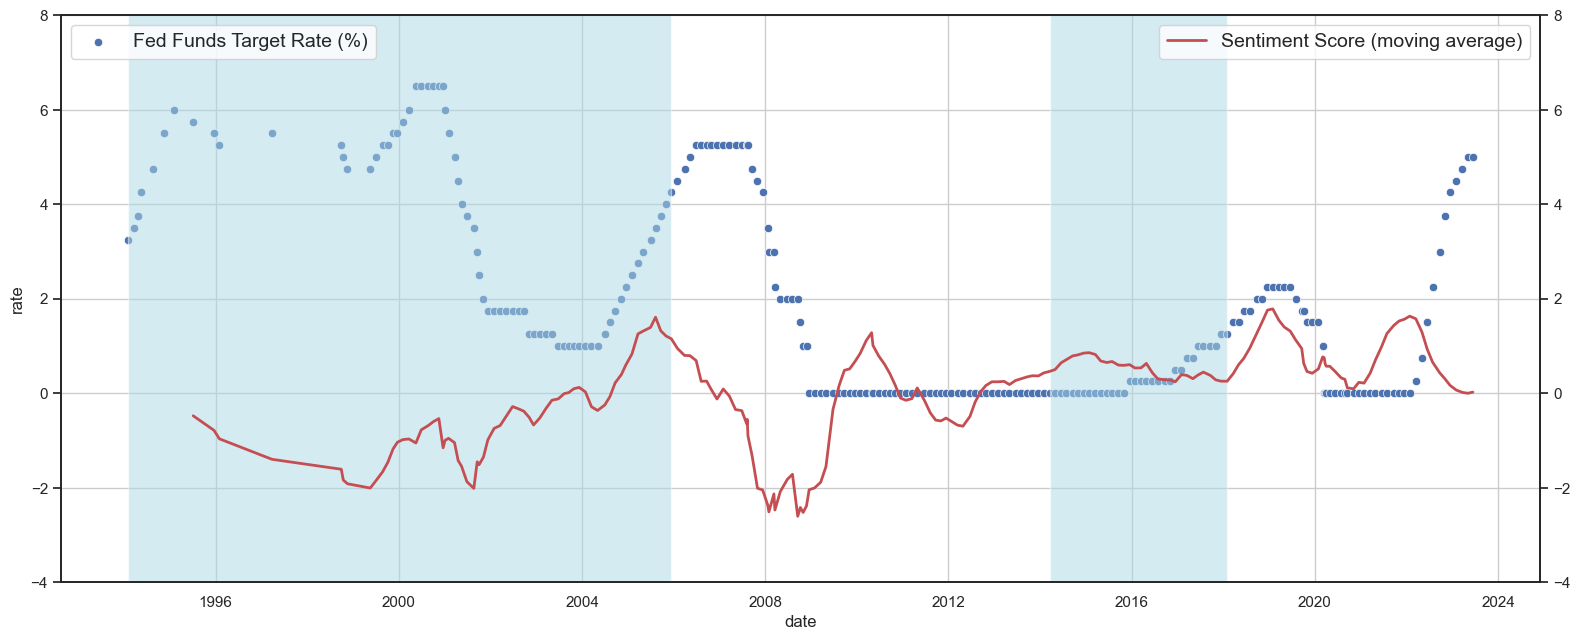

In [72]:
Window = 8
CompToMA = stmt_df['tone_score'].rolling(Window).mean()

fig, ax = plt.subplots(figsize=(17,7))
sns.scatterplot(x=stmt_df.index.get_level_values(0), y=stmt_df['rate'], ax=ax)
ax2 = ax.twinx() 
ax2.plot(stmt_df.index, CompToMA, c = 'r', linewidth= 2.0)
ax.legend(['Fed Funds Target Rate (%)'], loc=2, fontsize=14)
ax2.legend(['Sentiment Score (moving average)'], loc=1, fontsize=14)
#ax.set_xlim('1996-12', '2020-12')
ax.set_ylim(-4, 8)
ax2.set_ylim(-4, 8)
ax.grid(True)

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(stmt_df.index, 0, 10, where = chair, facecolor='lightblue', alpha=0.5, transform=trans)
ax.fill_between(stmt_df.index, 0, 10, where = recessions, facecolor='grey', alpha=0.5, transform=trans)

props = dict(boxstyle='round', facecolor='skyblue', alpha=0.2)
ax.text(0.15, -0.1, "Alan Greenspan", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.50, -0.1, "Ben Bernanke", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.75, -0.1, "Janet Yellen", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.90, -0.1, "Jerome Powell", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.14, 0.85, "Dot-com bubble", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.43, 0.85, "Financial crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.57, 0.85, "European debt \n crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.75, 0.85, "China stock \n turbulence", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.95, 0.85, "Covid-19", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


arrow_style = dict(facecolor='black', shrink=0.05)
ax.annotate('QE1', xy=('2008-11-25', 0), xytext=('2008-11-25', -3.5), size=16, ha='center', arrowprops=arrow_style)
ax.annotate('QE2', xy=('2010-11-03', 0), xytext=('2010-11-03', -3.5), size=16, ha='center', arrowprops=arrow_style)
ax.annotate('QE3', xy=('2012-09-13', 0), xytext=('2012-09-13', -3.5), size=16, ha='center', arrowprops=arrow_style)
ax.annotate('Tapering', xy=('2013-12-18', 0), xytext=('2013-12-18', -3.5), size=16, ha='center', arrowprops=arrow_style)

plt.title('Net Sentiment with Fed Rates, Resession and Chairpersons', fontsize=16)
plt.show()

# 4. Process economic indices data
The details can be found on `2_FOMC_Analysis_Preprocess_NonText.ipynb` and `4_FOMC_Analysis_EDA_NonText.ipynb`

## Taylor Rule
As a part of feature engineering, calculate taylor rules and see whether the first derivatives and difference from FED rate could be used. FED has released how policymakers use economic indices data, so try to calculate them from raw data. <BR />
https://www.federalreserve.gov/monetarypolicy/policy-rules-and-how-policymakers-use-them.htm

<img src='../img/taylor_rule.png' width="800">

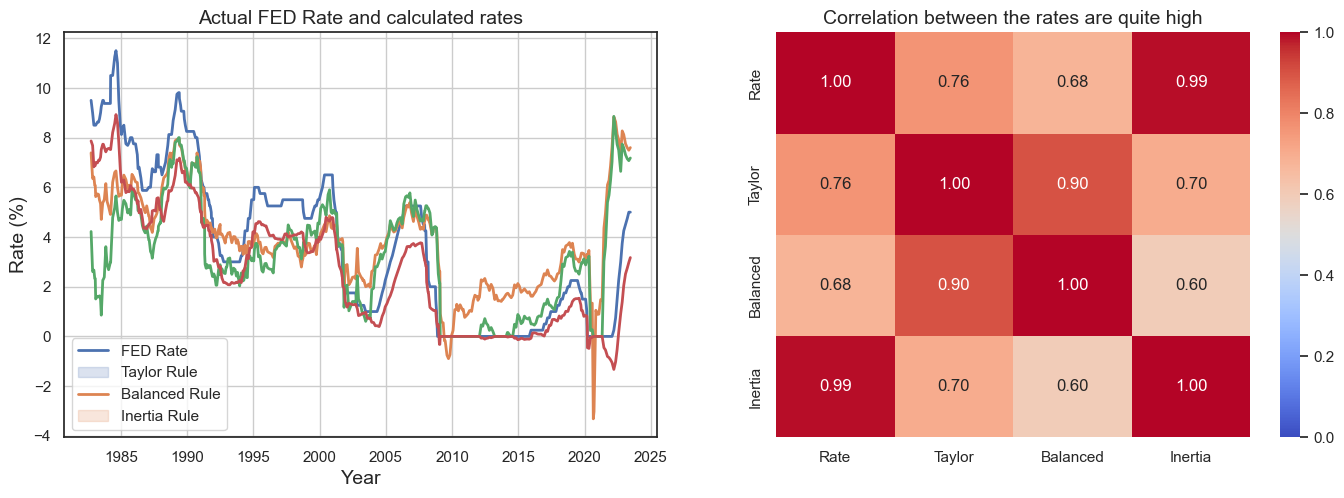

In [73]:
taylor=meta_df[['Rate', 'Taylor', 'Balanced', 'Inertia']]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=taylor, dashes=False, lw=2, ax=ax1)
ax1.grid(True)
ax1.set_title('Actual FED Rate and calculated rates', fontsize=14)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Rate (%)', fontsize=14)
ax1.legend(['FED Rate', 'Taylor Rule', 'Balanced Rule', 'Inertia Rule'])
sns.heatmap(taylor.astype(float).corr(), cmap="coolwarm", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax2)
ax2.set_title('Correlation between the rates are quite high', fontsize=14)
plt.show()

## Select features from meta data
Create moving average over different period, check correlation with Rate Decision (Raise/Hold/Lower) and select which features would be used as inputs for training. Also, impute the missing values.

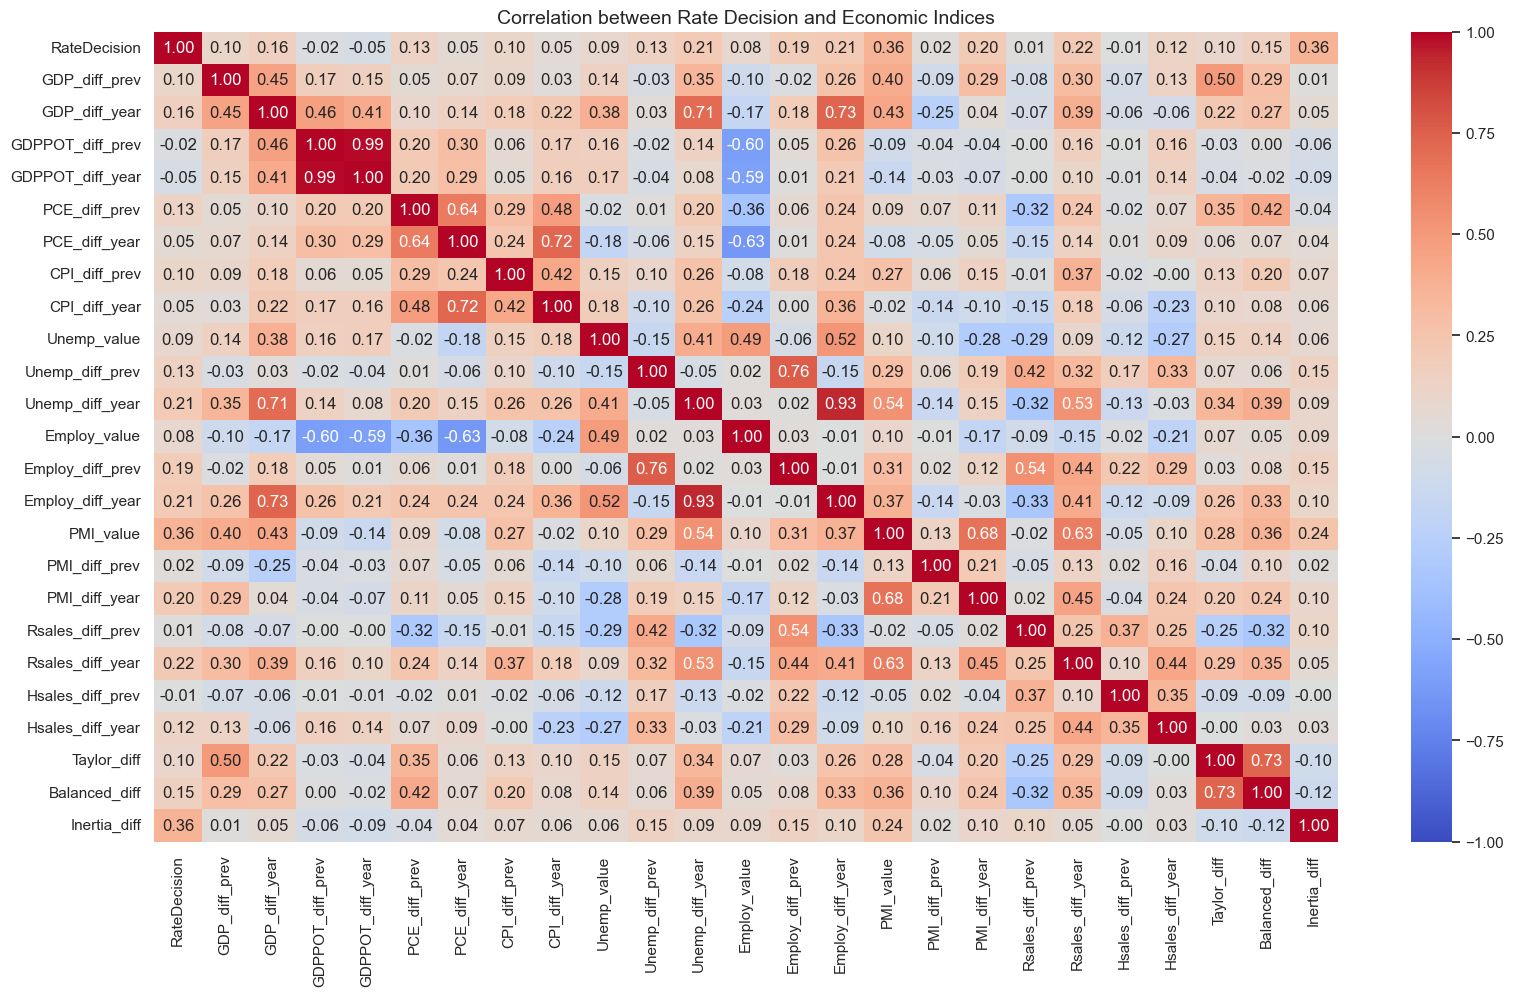

In [ ]:
corr_columns = ['RateDecision', 'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                'Taylor_diff', 'Balanced_diff', 'Inertia_diff']

fig, ax = plt.subplots(1, 1, figsize=(17, 10))

sns.heatmap(meta_df[corr_columns].astype(float).corr(), cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1, ax=ax)
ax.set_title("Correlation between Rate Decision and Economic Indices", fontsize=14)
plt.show()

/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_828/878107317.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(meta_df['PMI_value'][(meta_df["RateDecision"] == -1) & (meta_df['PMI_value'].notnull())], ax=ax1, color="Red", shade=True)
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_828/878107317.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(meta_df['PMI_value'][(meta_df["RateDecision"] == 0) & (meta_df['PMI_value'].notnull())], ax=ax1, color="Gray", shade=True)
/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_828/878107317.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(meta_df

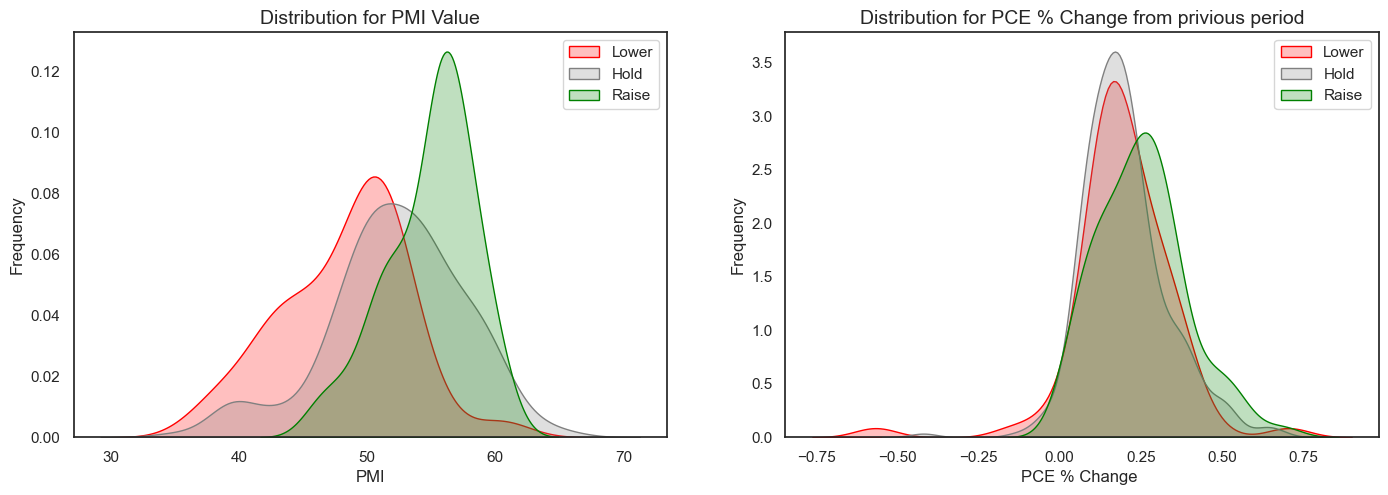

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(meta_df['PMI_value'][(meta_df["RateDecision"] == -1) & (meta_df['PMI_value'].notnull())], ax=ax1, color="Red", shade=True)
sns.kdeplot(meta_df['PMI_value'][(meta_df["RateDecision"] == 0) & (meta_df['PMI_value'].notnull())], ax=ax1, color="Gray", shade=True)
sns.kdeplot(meta_df['PMI_value'][(meta_df["RateDecision"] == 1) & (meta_df['PMI_value'].notnull())], ax=ax1, color="Green", shade=True)
ax1.set_xlabel('PMI')
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution for PMI Value", fontsize=14)
ax1.legend(["Lower", "Hold", "Raise"])
sns.kdeplot(meta_df['PCE_diff_prev'][(meta_df["RateDecision"] == -1) & (meta_df['PCE_diff_prev'].notnull())], ax=ax2, color="Red", shade=True)
sns.kdeplot(meta_df['PCE_diff_prev'][(meta_df["RateDecision"] == 0) & (meta_df['PCE_diff_prev'].notnull())], ax=ax2, color="Gray", shade=True)
sns.kdeplot(meta_df['PCE_diff_prev'][(meta_df["RateDecision"] == 1) & (meta_df['PCE_diff_prev'].notnull())], ax=ax2, color="Green", shade=True)
ax2.set_xlabel('PCE % Change ')
ax2.set_ylabel("Frequency")
ax2.set_title("Distribution for PCE % Change from privious period", fontsize=14)
ax2.legend(["Lower", "Hold", "Raise"])
plt.show()


# 5. Process text data
The details can be found in `3_FOMC_Analysis_Preprocess_Text.ipynb`

<img src="../img/text_process.png" width="800" align="left">

In [ ]:
file = open("../data/train_data/train_df.pickle", "rb")
train_df = pickle.load(file)
file.close()

In [ ]:
file = open("../data/FOMC/statement.pickle", "rb")
statement_df = pickle.load(file)
file.close()
print(statement_df.iloc[-2]['contents'].replace("\n[SECTION]\n", ""))

The Federal Reserve, the central bank of the United States, provides
          the nation with a safe, flexible, and stable monetary and financial
          system.

Federal Open Market Committee

Monetary Policy Principles and Practice

Policy Implementation

Reports

Review of Monetary Policy Strategy, Tools, and Communications

Institution Supervision

Reports

Reporting Forms

Supervision & Regulation Letters

Banking Applications & Legal Developments

Regulatory Resources

Banking & Data Structure

Financial Stability Assessments

Financial Stability Coordination & Actions

Reports

Regulations & Statutes

Payment Policies

Reserve Bank Payment Services & Data

Financial Market Utilities & Infrastructures

Research, Committees, and Forums

Working Papers and Notes

Data, Models and Tools

Bank Assets and Liabilities

Bank Structure Data

Business Finance

Dealer Financing Terms

Exchange Rates and International Data

Financial Accounts

Household Finance

Industrial Activity

Inte

In [ ]:
print(stmt_df.loc['2020-04-29']['text'])

The coronavirus outbreak is causing tremendous human and economic hardship across the United States and around the world. The virus and the measures taken to protect public health are inducing sharp declines in economic activity and a surge in job losses. Weaker demand and significantly lower oil prices are holding down consumer price inflation. The disruptions to economic activity here and abroad have significantly affected financial conditions and have impaired the flow of credit to U.S. households and businesses. The ongoing public health crisis will weigh heavily on economic activity, employment, and inflation in the near term, and poses considerable risks to the economic outlook over the medium term. In light of these developments, the Committee decided to maintain the target range for the federal funds rate at 0 to 1/4 percent. The Committee expects to maintain this target range until it is confident that the economy has weathered recent events and is on track to achieve its maxi

In [ ]:
print(stmt_df.loc['2020-04-29']['tokenized'])

['the', 'coronavirus', 'outbreak', 'cause', 'tremendous', 'human', 'economic', 'hardship', 'across', 'unite', 'state', 'around', 'world', 'the', 'virus', 'measure', 'take', 'protect', 'public', 'health', 'induce', 'sharp', 'decline', 'economic', 'activity', 'surge', 'job', 'loss', 'weaker', 'demand', 'significantly', 'lower', 'oil', 'price', 'hold', 'consumer', 'price', 'inflation', 'the', 'disruption', 'economic', 'activity', 'abroad', 'significantly', 'affect', 'financial', 'condition', 'impair', 'flow', 'credit', 'household', 'business', 'the', 'ongoing', 'public', 'health', 'crisis', 'weigh', 'heavily', 'economic', 'activity', 'employment', 'inflation', 'near', 'term', 'pose', 'considerable', 'risk', 'economic', 'outlook', 'medium', 'term', 'in', 'light', 'development', 'committee', 'decide', 'maintain', 'target', 'range', 'federal', 'fund', 'rate', 'percent', 'the', 'committee', 'expect', 'maintain', 'target', 'range', 'confident', 'economy', 'weather', 'recent', 'event', 'track',

In [ ]:
print(stmt_df.loc['2020-04-29']['token_ids'])

[17, 1291, 1292, 1083, 1321, 1322, 37, 1247, 1323, 216, 217, 172, 1324, 17, 1325, 83, 26, 1326, 1297, 1298, 502, 1091, 117, 37, 88, 1327, 340, 726, 950, 175, 342, 224, 646, 147, 414, 445, 147, 98, 17, 774, 37, 88, 530, 342, 1130, 220, 47, 1328, 1299, 364, 438, 437, 17, 273, 1297, 1298, 936, 539, 1329, 37, 88, 557, 98, 327, 328, 428, 538, 177, 37, 326, 1103, 328, 51, 173, 280, 9, 10, 406, 288, 1001, 6, 118, 24, 119, 17, 9, 19, 406, 288, 1001, 1217, 180, 1184, 140, 555, 1296, 693, 433, 557, 147, 390, 389, 17, 9, 296, 456, 1225, 634, 332, 37, 326, 306, 332, 79, 1297, 1298, 421, 222, 280, 704, 98, 14, 711, 978, 833, 756, 496, 180, 51, 1146, 367, 906, 237, 114, 31, 32, 33, 9, 385, 202, 19, 37, 47, 1078, 433, 557, 786, 377, 119, 98, 786, 50, 1177, 26, 370, 1020, 1001, 332, 306, 83, 272, 8, 47, 644, 98, 14, 98, 128, 675, 220, 1215, 280, 567, 496, 1299, 364, 438, 437, 6, 15, 296, 467, 872, 563, 879, 881, 1028, 563, 901, 278, 496, 382, 8, 159, 100, 101, 136, 1305, 32, 33, 840, 220, 47, 51, 747,

# 6. Build and Train Models
Take textual inputs and meta inputs to predict three classes: Raise, Hold or Lower
<img src="../img/model_overview.png" width="900">

The models are the same as Financial News / Tweets sentiment analysis but include meta inputs and concatinate them.
<img src="../img/model_0.png" width="900">
<img src="../img/model_A.png" width="900">
<img src="../img/model_B.png" width="900">
<img src="../img/model_C.png" width="900">
<img src="../img/model_D.png" width="900">
<img src="../img/model_E.png" width="900">
<img src="../img/model_F.png" width="900">


# Final Result

Due to the nature of long text per data and very small data set availability, the result was different from financial news and tweets analysis.
Simple lexicon approach with cosine similarity works well and better than more complex models as complex ones could not learn enough with limited data.
Finally, use of the trained BERT model to extract sentence-wise sentiment as inputs to the classification task outperformed the lexicon approach, which shows the sentiment analysis by BERT model could provide some meaningful insight to predict the FOMC decision.

As a future work, there're two main areas to improve:
1. Tackle the lack of enough training data - The models have clearly overfitted to train samples and failed to generalize well, espicially boosting algorithms are prone to overfitting. Hyperparameter tuning and imputation was considered there. In addition, configuraing the model and splitting data to augument the training data by synthetic approach could potentially benefitial. 
2. Improve input text quality - The input texts contain a lot of irrelevant paragraphs, which have nothing to to with FED target rate decision. For example, there are information about regulations, organisation structure and infrastructures. Filtering out less relevant inputs will improve the accuracy of the model prediction as well as training efficiency.

In [82]:
final_result_dict = {
    'model': ["Baseline"]*2 + ["A: Cosine Similarity"]*2 + ["B: Tfidf"]*2 + ["C: LSTM"]*2 + ["D: LSTM + GloVe"]*2 + ["E: BERT"]*2 + ["F: Prediction by BERT"]*2,
    'Metrics': ["Accuracy", "F1 Score"]*7,
    'score': [0.63, 0.50] + [0.78, 0.67] + [0.67, 0.33] + [0.54, 0.24] + [0.63, 0.41] + [0.59, 0.25] + [0.82, 0.73]
}
final_result = pd.DataFrame(final_result_dict)

In [83]:
final_result_dict = {
    'Model': ["Non-textual"]*2 + ["TFIDF+Cosine Similarity"]*2 + ["Prediction by BERT"]*2,
    'Metrics': ["Accuracy", "F1 Score"]*3,
    'Score': [0.61, 0.48] + [0.75, 0.61] + [0.76, 0.61]
}
final_result = pd.DataFrame(final_result_dict)

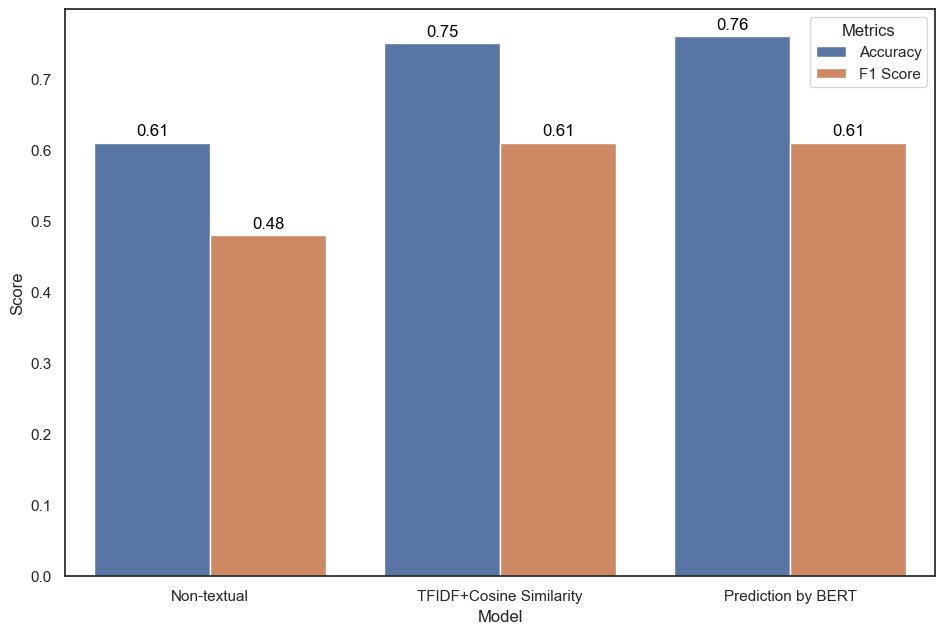

In [85]:
plt.figure(figsize=(10, 7))
g = sns.barplot(x='Model', y='Score', hue='Metrics', data=final_result)
for index, row in final_result.loc[final_result['Metrics']=='Accuracy'].iterrows():
    g.text(index/2-0.2, row.Score+0.01, row.Score, color='black', ha="center")
for index, row in final_result.loc[final_result['Metrics']=='F1 Score'].iterrows():
    g.text(index/2-0.3, row.Score+0.01, row.Score, color='black', ha="center")
plt.show()
